In [1]:
## Process AlpArray Switzerland for SKS-Splitting
## Gerrit Hein
######################################################
######### LOAD IN THE MODULES
######################################################
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

import matplotlib.pyplot as plt
import numpy as np

import os
import obspy
from obspy import read
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy.taup import TauPyModel
from obspy.geodetics.base import gps2dist_azimuth
from obspy.geodetics import locations2degrees
from obspy.taup import plot_travel_times
from obspy.geodetics import locations2degrees
from obspy.signal.rotate import rotate_ne_rt
from obspy.signal.polarization import particle_motion_odr

from obspy.signal.util import next_pow_2

import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit

from matplotlib.mlab import specgram
from scipy import stats


from tqdm import tqdm
import time

import multiprocessing

import splitwavepy as sw
######################################################
### 
######################################################


In [2]:
###############################################################
######### CHECK STATIONS AND EVENT CATALOGUE
###############################################################
client = Client("ETH") # ORFEUS
station= '*'
starttime = UTCDateTime("2000-01-01T00:00:00.000")
endtime = UTCDateTime("2018-12-31T00:00:00.000")

inventory = client.get_stations(network="CH", station=station, starttime=starttime, endtime=endtime)
stationlist = inventory[0]

HAMIK


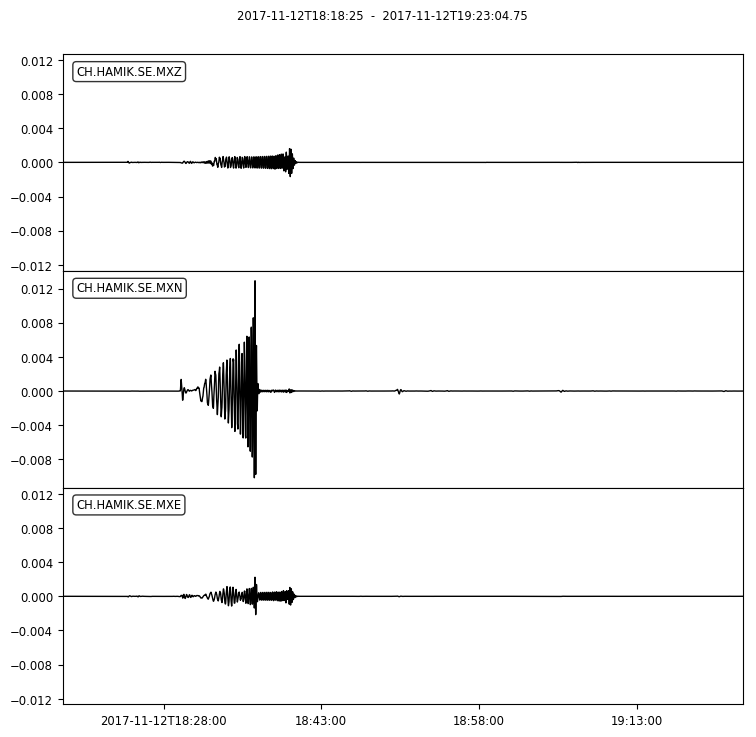

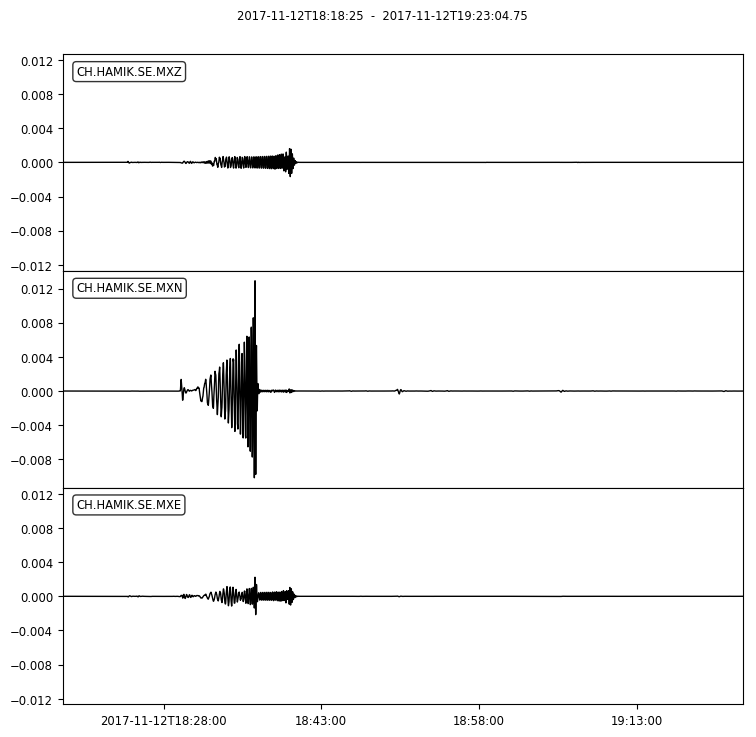

In [3]:
## TEST the whole procedure with Synthetics# from obspy.clients.syngine import Client
#  using AxiSEM (Nissen-Meyer et al., 2014), an axi-symmetric spectral element method for
# 3D (an-)elastic, anisotropic and acoustic wave propagation in spherical domains
from obspy.clients.syngine import Client

client = Client()
station = stationlist[90]
print(station.code)
st = client.get_waveforms(model="ak135f_5s", network="CH", station=station.code,eventid="GCMT:C201711121818A")
st.plot()  

## check artificial SKS split

#event1.preferred_origin_id.id
# event1.eventid
# station.get_contents()


/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/obspy/io/ndk/core.py:192: ObsPyNDKWarning: Skipped last 4 lines. Not a multiple of 5 lines.
  warnings.warn(msg, ObsPyNDKWarning)
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/obspy/io/cmtsolution/core.py:368: UserWarning: No body wave magnitude found. Will be replaced by the first magnitude in the event object.
  warnings.warn("No body wave magnitude found. Will be replaced by the "


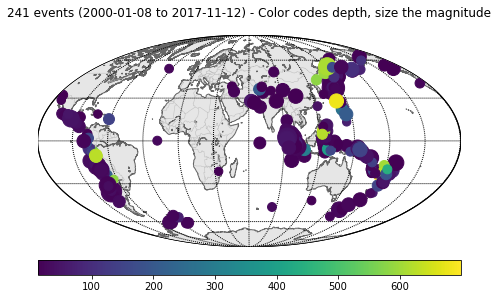

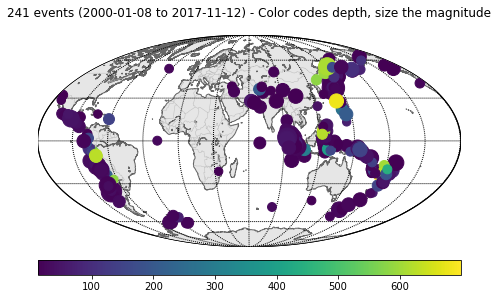

In [4]:
###############################################################
######### EVENT CATALOGUE
###############################################################
cat = obspy.read_events("/home/hein/Dropbox/PhD/code_PhD/qcmt.ndk")
#cat = cat.filter("time > {0}".format(station.start_date),"time < 2018-12-01T00:00:00")
cat = cat.filter("time > 2000-01-01T00:00","time < 2018-12-01T00:00:00")
cat_m7 = cat.filter("magnitude >= 7.0")
cat_m7.write("/home/hein/Dropbox/PhD/code_PhD/qcmt_edit.cmt",format="CMTSOLUTION")
cat_m7.plot() 

In [5]:
counter = 0
long_list = []

for ev in cat_m7:    
    event1 = ev
    ### Event parameters
    orig  = event1.origins

    mag = event1.magnitudes[0]
    
    for station in stationlist:        
        ### check if station has recorded before event 
        if (float(station.start_date)<float(orig[0].time)) and (station.end_date == None):


            dist_deg = locations2degrees(orig[0].latitude, orig[0].longitude,
                           station.latitude, station.longitude)
            ## check wheter distance is in the right range            
            if (dist_deg>95) and (dist_deg<145):
                counter +=1

                tmp = [counter, str(station.code), station.start_date, station.latitude,
                                              station.longitude, orig[0].time,
                                    orig[0].latitude, orig[0].longitude, orig[0].depth, mag.mag, dist_deg]
                long_list.append(tmp)


In [6]:
#################################################################################
######### READ STATION SKRIPT
#################################################################################
def read_station_event_data(istation):
    #### to get all waveforms of 1 station
    st_lat_list = []
    st_lon_list = []        
    ev_lat_list =[]
    ev_lon_list =[]
    ev_time_list = []
    ev_depth_list = []    
    ev_mag_list = []
    ev_dist_list = []
    back_azimut_list =[]    
    t_SKS_list = []
    t_SKKS_list = []
    t_SKS=0     
    t_SKKS=0 
    t_PP=0     
    t_PP_list = []    

    PHASE_LIST = ['PP','SKS','SKKS']
    st_event = obspy.Stream()
    for iSKS in long_list:    
#    for iSKS in long_list[0:25]:
        
        if iSKS[1]==istation:
#            print(iSKS[1])
            filename='{0}/{1}/{2}.{3}.{4}.{5}.{6}.{7}.CH.{8}.BH?..SAC'.format(save_loc,iSKS[1],iSKS[5].year,
                                                              iSKS[5].julday,iSKS[5].hour,
                                                              iSKS[5].minute,iSKS[5].second,
                                                              iSKS[5].microsecond/100,
                                                              iSKS[1])

        ## something which only gets the data for 1 events
#            print(filename)
            st_tmp=obspy.Stream()
            try:
            
        #                print('reading', iSKS[1])
                st_tmp += read(filename)

                if len(st_tmp)>2:

                    if (st_tmp[0].stats.npts > 36000 and st_tmp[1].stats.npts > 36000 and st_tmp[2].stats.npts > 36000):


                        st_lat = iSKS[3]
                        st_lon = iSKS[4]
                        ev_time = UTCDateTime(iSKS[5])     
                        ev_lat = iSKS[6]
                        ev_lon = iSKS[7]
                        ev_depth = iSKS[8]
                        ev_mag = iSKS[9]  
                        ev_dist = iSKS[10]

                        st_lat_list.append(st_lat)
                        st_lon_list.append(st_lon)                    
                        ev_lat_list.append(ev_lat)
                        ev_lon_list.append(ev_lon)        
                        ev_time_list.append(ev_time)
                        ev_depth_list.append(ev_depth)
                        ev_mag_list.append(ev_mag)
                        ev_dist_list.append(ev_dist)

                        dist_deg = locations2degrees(ev_lat,ev_lon,
                                   st_lat,st_lon)

                        arrivals = model.get_travel_times(source_depth_in_km=ev_depth/1000, distance_in_degree=dist_deg,phase_list=PHASE_LIST)

                        geodetics = gps2dist_azimuth(ev_lat, ev_lon,
                               st_lat, st_lon, a=6378137.0, f=0.0033528106647474805)

                        back_azimut = geodetics[2]
                        back_azimut_list.append(back_azimut)

                        for i in range(0,len(arrivals)):
                            if arrivals[i].name=='SKS':
                                t_SKS = arrivals[i].time
                            elif (arrivals[i].name=='SKKS' and t_SKKS==0):
                                t_SKKS = arrivals[i].time     
                            elif arrivals[i].name=='PP':
                                t_PP = arrivals[i].time

                        t_SKS_list.append(t_SKS)
                        t_SKKS_list.append(t_SKKS)                        
                        t_PP_list.append(t_PP)                                                

                        st_event +=st_tmp
                    else:
                        print('Stream has too few samples')
                else:
                    print('Stream has not 3 channels')



            except:
                print('no matching file')
            

    return st_event,st_lat_list,st_lon_list,ev_lat_list,ev_lon_list,ev_time_list,ev_depth_list,ev_mag_list,ev_dist_list,back_azimut_list, t_SKS_list,t_SKKS_list,t_PP_list


In [7]:
#################################################################################
######### SPLITWAVE ROUTINES 
#################################################################################

    

def Splitwave_Eig3D(st_cut,plot=False):

    tmp = st_cut
    delta = tmp[0].stats.delta
#    print(delta)
    t = sw.Trio(tmp[1].data,tmp[0].data, tmp[2].data,delta=delta)
    #t = sw.Pair(st_slice[1].data,)

    ## write something for time window
    t1 = 10
    t2 = 70
    t.set_window(t1,t2)
#    t.plot()

    b = sw.Eig3dM(t,lags=(2.5,))
    
    try:  
        path_Methods='{0}/../SplitWave_Results/Methods/Eig3D/{1}/'.format(save_loc,st_cut[0].stats.station)
#        os.mkdir(path_Methods)
    except:
        pass
#    b.save('/media/hein/home2/SplitWave_Results/Splitws/Window_Tests/{0}_{1}.eig'.format(st_cut[0].stats.station,st_cut[0].stats.starttime.strftime("%Y-%m-%d")))    
    if plot==True:
        fig = b.plot()
        fig.savefig('/media/hein/home2/SplitWave_Results/Splitws/Window_Tests{0}/{0}_{1}.eig'.format(st_cut[0].stats.station, st_cut[0].stats.starttime.strftime("%Y-%m-%d")))
    

    return b.fast, b.dfast,round(b.lag,4),round(b.dlag,4)


def Splitwave_EigM(st_cut,t1,t2,plot=False):
    # get data into Pair object and plot
    tmp = st_cut    
    north = tmp[1].data
    east = tmp[0].data
    sample_interval = tmp[0].stats.delta
    try:  
        realdata = sw.Pair(north, east, delta=sample_interval)
        ## write something for time window    
        t1 = t1
        t2 = t2
        realdata.set_window(t1,t2)
       # realdata.plot()

        measure = sw.EigenM(realdata,lags=(2.5,))
    except:
        print('Time Window Too Short, set vals to nan')        
        measure = sw.CrossM(delta=0.1)
        measure.fast = np.nan
        measure.dfast = np.nan
        measure.lag = np.nan
        measure.dlag = np.nan
        pass
    
#    measure.save('/media/hein/home2/SplitWave_Results/Methods/EigM/{0}_{1}.eig'.format(st_cut[0].stats.station,st_cut[0].stats.starttime.strftime("%Y-%m-%d")))    
    if plot==True:
#         fig,ax = plt.figure(figsize=(16,9))
        measure.plot()
#         fig.savefig('/media/hein/home2/SplitWave_Results/Splitws/Window_Tests{0}/EigM_{0}_{1}.eig'.format(st_cut[0].stats.station, st_cut[0].stats.starttime.strftime("%Y-%m-%d")))    
    
    return measure.fast, measure.dfast,round(measure.lag,4),round(measure.dlag,4)


def Splitwave_TransM(st_cut,t1,t2,back_az,plot=False):
    tmp = st_cut    
    north = tmp[1].data
    east = tmp[0].data
    sample_interval = tmp[0].stats.delta
    ## write something for time window    
    try:      
        realdata = sw.Pair(north, east, delta=sample_interval)        
        t1 = t1
        t2 = t2
        realdata.set_window(t1,t2)
        #realdata.plot()

        m = sw.TransM(realdata, pol=back_az, lags=(2.5,))
    except:
        print('Time Window Too Short, set vals to nan')
        m = sw.CrossM(delta=0.1)
        m.fast = np.nan
        m.dfast = np.nan
        m.lag = np.nan
        m.dlag = np.nan
        pass

    
    if plot==True:
#         fig,ax = plt.figure(figsize=(16,9))
        m.plot()

#         fig.savefig('/media/hein/home2/SplitWave_Results/Splitws/Window_Tests{0}/TransM_{0}_{1}.eig'.format(st_cut[0].stats.station, st_cut[0].stats.starttime.strftime("%Y-%m-%d")))

    return m.fast, m.dfast,round(m.lag,4),round(m.dlag,4)


def Splitwave_CrossC(st_cut,t1,t2,plot=False):
    tmp = st_cut    
    north = tmp[1].data
    east = tmp[0].data
    sample_interval = tmp[0].stats.delta
#     realdata = sw.Pair(north, east, delta=sample_interval)
#     ## write something for time window    
#     t1 = t1
#     t2 = t2
    try:  
        realdata = sw.Pair(north, east, delta=sample_interval)
        ## write something for time window    
        t1 = t1
        t2 = t2

        realdata.set_window(t1,t2)
      #  realdata.plot()

        m = sw.CrossM(realdata, lags=(2.5,))
    except:
        print('Time Window Too Short, set vals to nan')
        m = sw.CrossM(delta=0.1)
        m.fast = np.nan
        m.dfast = np.nan
        m.lag = np.nan
        m.dlag = np.nan
        pass
#     realdata.set_window(t1,t2)
#   #  realdata.plot()

#     m = sw.CrossM(realdata, lags=(2.5,))
    
#    m.save('/media/hein/home2/SplitWave_Results/Splitws/Window_Tests{0}/{0}_{1}.eig'.format(st_cut[0].stats.station, st_cut[0].stats.starttime.strftime("%Y-%m-%d")))
    if plot==True:
#         fig,ax = plt.figure(figsize=(16,9))
        m.plot()
#         fig.savefig('/media/hein/home2/SplitWave_Results/Splitws/Window_Tests{0}/CrossC_{0}_{1}.eig'.format(st_cut[0].stats.station, st_cut[0].stats.starttime.strftime("%Y-%m-%d")))

    
    return m.fast, m.dfast,round(m.lag,4),round(m.dlag,4)

def calc_sft(st,t1,t2):    
    st_slice = st.slice(starttime=t1,endtime=t2)
    max_percentage=0.05
#    st_slice = st_slice.filter("bandpass",freqmin=0.1,freqmax=0.5)
    
    st_slice = st_slice.taper(max_percentage, type='hann', max_length=None, side='both')

    ## to be entirely sure, take the maximum energy on E and N component
    st_amplitude = np.sqrt(st_slice[0].data**2+st_slice[1].data**2)
    winlen=10
    power = 2**7 #NFFT=winlen*st_slice[0].stats.sampling_rate
    s, f, t = specgram(st_slice[0].data,NFFT=power, noverlap=int(power*0.5),pad_to=int(power*2),Fs=10)    
    slog = 10 * np.log10(s)
    #print(st_slice)
    return s,f,t,slog,st_slice



In [8]:
#################################################################################
######### CHEVROT METHOD 
#################################################################################
## take time window of N and E wave
## get particle direction for max pulse
## rotate to RT
## calc Splitting Vector 
## generalize for EVENTS
## now calc for several events
## make azimuth vs SV amplitude plot
## fit a Least Square sinusoid
def get_real_SKS_arrival(st_work):

    
    ampl = np.sqrt(st_work[0].data**2+st_work[1].data**2)
    max_ampl = np.max(ampl)
    max_idx = np.argmax(ampl)    
    tvec = np.linspace(float(st_work[0].stats.starttime),float(st_work[0].stats.endtime),st_work[0].stats.npts)
    t_SKS_real = tvec[max_idx]
    t_SKS_real = UTCDateTime(t_SKS_real)
    
    return t_SKS_real


def get_latest_start(st_cut):

    latest_start = [float(st_cut[0].stats.starttime),float(st_cut[1].stats.starttime),float(st_cut[2].stats.starttime)]
    
    least_samps = [float(st_cut[0].stats.npts),float(st_cut[1].stats.npts),float(st_cut[2].stats.npts)]
            
    ## make new trace with the minimum
    st_cut[0].data = st_cut[0].data[:int(min(least_samps))]
    st_cut[1].data =st_cut[1].data[:int(min(least_samps))]
    st_cut[2].data = st_cut[2].data[:int(min(least_samps))]
#    st_cut = st_cut.slice(UTCDateTime(np.max(latest_start)),UTCDateTime(np.max(latest_start))+np.min(least_samps)-10,nearest_sample=True)
#    print(st_cut)
    
    return st_cut



def splittingintensity(rdiff,trans):
    """
    Calculate splitting intensity.
    """
    s = -2 * np.trapz(trans * rdiff) / np.trapz(rdiff**2)
    return s




def SKS_Intensity_Chevrot(st_c,ev_time,t_SKS,back_azimut,twin,plot=False):
    
    plt.rcParams.update({'font.size': 12})
    st_c = st_c.sort()
#    for ev_step in range(0,len(ev_time_l)):    
    ### SORT IT AS ZNE

    st_stream = obspy.Stream()
    tmp = st_c[2]
    st_stream +=tmp
    tmp = st_c[1]
    st_stream +=tmp
    tmp = st_c[0]
    st_stream +=tmp

    gridspec.GridSpec(2,3)
    arrival_time = ev_time+t_SKS

    ### USE CORRECT ARRIVAL TIME
    ### Take small time window around arrival time 
    twin = twin

    st_stream = st_stream.slice(arrival_time-twin,arrival_time+twin,nearest_sample=True)

    st_stream = get_latest_start(st_stream) ## FOR ISSUE WITH UNEVEN SAMPLES 

    
    limits=np.max([abs(st_stream[2].data),abs(st_stream[2].data)])*2*10**6

    #### CALC THE POLARIZATION OF PARTICLE MOTION
    ## only accept the upper half for Signal
    noise_level=st_stream[0].data**2+st_stream[1].data**2+st_stream[2].data**2
    azimuth, incidence, az_error, in_error = particle_motion_odr(st_stream, noise_thres=np.mean([np.max(noise_level), np.min(noise_level)])+np.std([np.max(noise_level), np.min(noise_level)]))
#    print(az_error)
    ### ROTATE THE SYSTEM FROM NE TO RT
    st_rot_RT = rotate_ne_rt(st_stream[1].data,st_stream[2].data,180+azimuth)    
    
    radial = st_rot_RT[0]
    r_dot = np.diff(radial)/st_stream[1].stats.delta
        
    radial = radial[0:len(r_dot)]
    transverse=st_rot_RT[1][0:len(r_dot)]    

    r_2 = np.sum(r_dot**2)
    ### NORMALIZE SPLITTING VECTOR
    SV_EQ = -np.sum(2*r_dot*transverse)/r_2
    ## same with walpoles implementation, so clean up?
#    s = splittingintensity(r_dot,transverse)
#    print('Walpole ',s)
#    print('me',SV_EQ)


    sigma = np.sqrt(np.sum((transverse+0.5*r_dot*SV_EQ)**2))
#    print(sigma)
    
    ### EVENT AZIMUT IS BACK-AZIMUT +180
    if back_azimut+180>360:
        Az = back_azimut-180
    else:
        Az=back_azimut+180
    SV_Az = SV_EQ 

    if plot==True:
    ### Only Plotting Below     
        fig = plt.figure(figsize=(16,9))
#        plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=1)        
        ax1 = fig.add_axes([0.1,0.5,0.5,0.3])    
        ax2 = fig.add_axes([0.65,0.5,0.25,0.3])        
        ax3 = fig.add_axes([0.1,0.1,0.5,0.3])     
        ax4 = fig.add_axes([0.65,0.1,0.25,0.3])            
        
        timevec = np.linspace(float(st_stream[0].stats.starttime),float(st_stream[0].stats.endtime),st_stream[0].stats.npts)

        xxticks = np.linspace(timevec[0], timevec[-1],10)
        xxlabels=[]
        for i in range(0,len(xxticks)):
            tmp=UTCDateTime(xxticks[i]).strftime('%H:%M:%S')
            xxlabels.append(tmp)
            
    ########### SET PROPER TIME AXIS    


        ax1.plot(timevec,st_stream[1].data*10**6,'g',label='North')
        ax1.plot(timevec,st_stream[2].data*10**6,'b',label='East')
        ax1.vlines(x=float(arrival_time),ymin=1.3*np.min(np.min([st_stream[1].data*10**6,st_stream[2].data*10**6])),ymax=1.3*np.max(np.max([st_stream[1].data*10**6,st_stream[2].data*10**6])),color='k',linewidth=0.5,label='SKS-Phase')
        ax1.set_title('{0}, SKS-arrival at: {1}, Backazimut={2} $^\circ$, SI={3}'.format(st_stream[0].stats.station,arrival_time.strftime('%Y-%m-%d, %H:%M:%S'),round(Az,2),round(SV_Az,2)))
        ax1.set_xlabel('Time [s]')
        ax1.set_ylabel('displacement [$\mu$m]')  
        ax1.set_xlim(timevec[0],timevec[-1])            
        ax1.set_xticks(xxticks)
        ax1.set_xticklabels(xxlabels)            
        ax1.grid()        
        ax1.legend()

#        plt.subplot2grid((2,3), (0,2))
        ax2.plot(st_stream[2].data*10**6,st_stream[1].data/10**-6,color='black',linestyle='dashed')
        ax2.set_xlabel('East disp. [$\mu$m]')
        ax2.set_ylabel('North disp. [$\mu$m]')
        ax2.axis('equal')
        ax2.set_xlim(-limits, limits)
        ax2.set_ylim(-limits, limits)
        ax2.grid()
        ax2.set_title('Polarization: Azimuth={0}$^\circ$'.format(round(azimuth,2)))
        
#        limits = 1        
#        limits = np.max([np.max(radial),np.max(transverse)])
    
# #        plt.subplot2grid((2,3), (1,0), colspan=2, rowspan=1)
        ax3.plot(timevec[0:-1],radial*10**6,'r',label='Radial')
        ax3.plot(timevec[0:-1],transverse*10**6,'b',label='Transverse') 
        ax3.plot(timevec[0:-1],-0.5*r_dot*(np.max(transverse)/np.max(r_dot))*10**6,color='g',label='radial-derivate',alpha=0.5,linewidth=0.5)
        ax3.vlines(x=float(arrival_time),ymin=1.3*np.min(np.min([st_stream[1].data*10**6,st_stream[2].data*10**6])),ymax=1.3*np.max(np.max([st_stream[1].data*10**6,st_stream[2].data*10**6])),color='k',linewidth=0.5,label='SKS-Phase')        
        ax3.set_xlabel('Time [s]')
        ax3.set_ylabel('displacement [$\mu$m]')                        
        ax3.set_xlim(timevec[0],timevec[-1])            
        ax3.set_xticks(xxticks)
        ax3.set_xticklabels(xxlabels)                    
        ax3.grid()        
        ax3.set_title('rotated System')        
        ax3.legend()

#        plt.subplot2grid((2,3), (1,2))
        ax4.plot(radial*10**6,transverse*10**6,color='black',linestyle='dashed')
        ax4.set_xlabel('Radial disp. [$\mu$m]')
        ax4.set_ylabel('Transverse  disp. [$\mu$m]')
        ax4.axis('equal')        
#        ax4.set_xlim(-limits, limits)
#        ax4.set_ylim(-limits, limits)
        ax4.grid()

        try:  
            path_Methods='/media/hein/home2/SplitWave_Results/Splitting_Intensity/{0}/'.format(st_stream[0].stats.station)
#             os.mkdir(path_Methods)
        except:  
            pass
#         plt.savefig('/media/hein/home2/SplitWave_Results/Splitting_Intensity/{0}/{0}_{1}'.format(st_stream[0].stats.station,arrival_time.strftime('%Y-%m-%d, %H:%M:%S')))
#         plt.close()
#        fig.close()
#    plt.show()

    return Az,SV_Az

## SINOSOID FUNCTION TO BE FIT THROUGH DATA
def func(x, delta_t, phi):
    y = delta_t *0.5*np.sin( 2*(np.radians(x)-phi))
    return y


def get_best_dt_and_phi(Az,SV_Az,station, plot=False):
#    print(SV_Az)
    popt = np.zeros(2)
    #try:

    # sort out extrem values
    Az = np.asarray(Az)
    SV_Az = np.asarray(SV_Az)
    xdata = Az
    ydata = SV_Az
    
#     allow_max = 1.5 # lets see how good that works
#     xdata = Az[np.where((SV_Az<=allow_max) & (SV_Az>=-allow_max))]
#     ydata = SV_Az[np.where((SV_Az<=allow_max) & (SV_Az>=-allow_max))]
    
    ### FIT CURVE THROUGH DATA
    popt, pcov = curve_fit(func, xdata, ydata,  bounds=([0, -np.pi], [3, np.pi]))
    azi_theo = np.linspace(0,360)
    perr = np.sqrt(np.diag(pcov))

    
    if plot==True:
        plt.figure(figsize=(16,8))
        plt.plot(xdata, ydata, 'ko',label='data')

#        plt.plot(xdata, func(xdata, *popt), 'rx',label='prediction')
        
        plt.errorbar(xdata, ydata, xerr=perr[1]*180/np.pi, yerr=perr[0],color='red',alpha=0.5 ,label='errorbars', fmt='o')
        
        
#       plt.plot(azi_theo,func(azi_theo,popt[0]+perr[0],(popt[1]+perr[1])*180/np.pi),color='red',linestyle='dashed',linewidth=0.5,label='1x $\sigma$')
#       plt.plot(azi_theo,func(azi_theo,popt[0]-perr[0],(popt[1]-perr[1])*180/np.pi),color='red',linestyle='dashed',linewidth=0.5)        
        #plt.plot(azi_theo,func(azi_theo,popt[0]+perr[0],(popt[1])*180/np.pi),color='red',linestyle='dashed',linewidth=0.5)    
        plt.plot(azi_theo,func(azi_theo,popt[0],popt[1]),color='black',linestyle='dashed',label='fit')
        plt.xlabel('Azimuth [$^\circ$]')
        plt.ylabel('Amplitude')
        plt.grid()
        plt.xlim(0,360)
#        plt.ylim(-2,2)
#        plt.ylim(-allow_max-1,allow_max+1)        
        plt.title('{4}, best parameters $\Delta$t={0}$\pm${1} s, $\phi$={2}$\pm${3}$^\circ$'.format(round(popt[0],2),round(perr[0],3),round(popt[1]*180/np.pi,2),round(perr[1]*180/np.pi,3),station))
        plt.legend()
#         plt.savefig('/media/hein/home2/SplitWave_Results/SKS/Chevrot/Splitting_Intensity_fit_{0}.png'.format(station))
#         plt.close()

#     except:
#         print('some Problem')
#         popt[0]=np.nan
#         popt[1]=np.nan
#         pass
    return popt[0],popt[1]*180/np.pi,perr[0],perr[1]*180/np.pi



def n_event_st_cut(nevent):
    st_selection = st_ev[3*nevent:3*nevent+3]
    #st_selection.plot()
    ## cut small time window around theoretical SKS-Arrival
    twin = 60
    max_percentage=0.05
    ## get real SKS ARRIVAL FIRST 
    ## check (max(abs on Horizontal)) within 2 min around theoretical 
    ## and cut 2 minutes around this maximum
    
    ### initial cut around theoretical arrival
    st_cut = st_selection.slice(starttime=ev_time_l[nevent]+t_SKS_l[nevent]-twin,endtime=ev_time_l[nevent]+t_SKS_l[nevent]+twin)
    t_SKS_real = get_real_SKS_arrival(st_cut)
    st_cut = st_selection.slice(starttime=t_SKS_real-twin,endtime=t_SKS_real+twin)
    st_cut = st_cut.taper(max_percentage, type='hann', max_length=None, side='both')

    return st_cut

def calc_SNR(st_cit):
    S = np.max(np.sqrt(st_cit[0].data**2+st_cit[1].data**2))
    RMS_N = np.mean(np.sqrt(st_cit[0].data**2+st_cit[1].data**2))
    SNR = 10*np.log10(S/RMS_N)
    return SNR


def write_head(path, method, station, header):
    fnam_out = os.path.join(path, '{1}/SKS_Splitting_{0}_{1}.txt'.format(station,method))
    print('wrote into:', fnam_out)
                            
    with open(fnam_out, 'w') as fid:
        fid.write('# ' + header + '\n')
        
def write_SKS_Results_M(path, method,vals,station, header):
    fnam_out = os.path.join(path,
                            '{0}/SKS_Splitting_{1}_{0}.txt'.format(method,station))
#    print(fnam_out)
    fmt = '%s \n'    
    vals_array = np.asarray(vals)
#    print(vals_array)

    with open(fnam_out, 'a') as fid:      
        arraystring = np.array2string(vals_array[:], 
                                      precision=4,
                                      max_line_width=255)
        fid.write(fmt % (arraystring[1:-1]))
        
        
def write_head_CHEV(path, method, header):
    fnam_out = os.path.join(path, 'SKS_Splitting_{0}.txt'.format(method))
    print('wrote into:', fnam_out)
                            
    with open(fnam_out, 'w') as fid:
        fid.write('# ' + header + '\n')        
        
                            
def write_SKS_Results_CHEV(path, method, vals, header):
    fnam_out = os.path.join(path,
                            'SKS_Splitting_{0}.txt'.format(method))
#    print(fnam_out)
    fmt = '%s \n'    
    vals_array = np.asarray(vals)
#    print(vals_array)

    with open(fnam_out, 'a') as fid:      
        arraystring = np.array2string(vals_array[:], 
                                      precision=4,
                                      max_line_width=255)
        fid.write(fmt % (arraystring[1:-1]))            
        
txt_path = '/media/hein/home2/SplitWave_Results/Splitws/Time_Window_Test/TXT'

header='Station.code, ' + \
        'Station.lat [°],' + \
        'Station.lon [°],' + \
        'Event time, ' + \
        'Event depth [km], ' + \
        'Event mag, '+ \
        'Event lat [°], ' + \
        'Event lon [°], ' + \
        'best fast dir [°], ' + \
        'dfast dir [°], ' +\
        'best lag [s], ' + \
        'dlag [s], ' + \
        'SNR [dB], ' + \
        'window param t1 [s], ' + \
        'window param t2 [s], ' + \
        'Chi-Squared-phi ' + \
        'p-value-phi, ' + \
        'Chi-Squared-dt, ' + \
        'p-value-dt'

header2='Station.code, ' + \
        'fast dir [°]' + \
        'dfast dir [°], ' + \
        'dt [s],' + \
        'dlag [s],' + \
        'best twin [s]' +\
        'Chi-Squared-phi ' + \
        'p-value-phi, ' + \
        'Chi-Squared-dt, ' + \
        'p-value-dt' + \
        'number Events'


In [9]:
# save_loc = '/media/hein/home2/SplitWave_Data'
# print(save_loc)


# FMT = 'SAC'
# Splitting_windows = True
# plot_SplitW = False
# mod = 'ak135' ##mod = 'iasp91'
# model = TauPyModel(model=mod)

# new_stat_list = os.listdir(save_loc) ## Get A list of downloaded Stations

# ### CHOOSE STATION and load all waveforms 
# method= 'Chevrot'
# write_head_CHEV(txt_path, method,header2)


# #for istation in range(0,new_stat_list):
# #for istation in range(0,2):    
    
# station = new_stat_list[0]
# ## Somewhere here write Head for Chevrot 

# st_ev,st_lat_l,st_lon_l,ev_lat_l,ev_lon_l,ev_time_l,ev_depth_l,ev_mag_l,ev_dist_l,back_azimut_l, t_SKS_l,t_SKKS_l,t_PP_l = read_station_event_data(station)

In [11]:
start_time = time.time()

save_loc = '/media/hein/home2/SplitWave_Data'
print(save_loc)


FMT = 'SAC'
Splitting_windows = True
plot_SplitW = False
mod = 'ak135' ##mod = 'iasp91'
model = TauPyModel(model=mod)

new_stat_list = os.listdir(save_loc) ## Get A list of downloaded Stations

### CHOOSE STATION and load all waveforms 
method= 'Chevrot'
write_head_CHEV(txt_path, method,header2)

########################################################################################################################################################################
########################################################################################################################################################################
#for istation in range(0,len(new_stat_list)):
#for istation in range(0,len(new_stat_list)):    
for istation in tqdm(range(0,len(new_stat_list))):        
#for istation in tqdm(range(0,10)):        
### LOOOP AROUND    
    station = new_stat_list[istation]

    print('Loading in Waveforms')
    st_ev = obspy.Stream()
    st_ev,st_lat_l,st_lon_l,ev_lat_l,ev_lon_l,ev_time_l,ev_depth_l,ev_mag_l,ev_dist_l,back_azimut_l, t_SKS_l,t_SKKS_l,t_PP_l = read_station_event_data(station)
    ########################################################################################################################################################################
    ########################################################################################################################################################################
    ### MAIN FUNCTION TO FIRST CALCULATE CHEVROT FOR ALL EVENTS

    ntwindows = 60  ### test 50 timw windows

    Az_l  = np.zeros((len(ev_time_l),ntwindows))
    SV_Az_l = np.zeros((len(ev_time_l),ntwindows))



    for nevent in range(0,len(ev_time_l)):
    #for nevent in range(0,3):    

        st_cut = n_event_st_cut(nevent)
        t_SKS_real = get_real_SKS_arrival(st_cut)
        ### BLOCK FOR CHEVROT

        twindows = np.linspace(1,45,ntwindows)
        #twindows = 0.1

        for iwindow in range(0,len(twindows)):
        #    print(twindows[iwindow])

            Az,SV_Az = SKS_Intensity_Chevrot(st_cut,ev_time_l[nevent],float(t_SKS_real)-float(ev_time_l[nevent]),back_azimut_l[nevent],twindows[iwindow],plot=False)
            Az_l[nevent,iwindow] = Az
            SV_Az_l[nevent,iwindow] = SV_Az



    val_4 = np.zeros((ntwindows,4))

    for iwin in range(0,len(twindows)):

        dt,phi,std_dt,std_phi = get_best_dt_and_phi(Az_l[:,iwin],SV_Az_l[:,iwin],st_cut[0].stats.station)
        val_4[iwin,:] = (dt,phi,std_dt,std_phi)
            ## write out results for Chevrot

    #### CHI2 TEST
    chisquare_dt4,p_dt4 = stats.chisquare(val_4[:,0])
    chisquare_phi4,p_phi4 = stats.chisquare((val_4[:,1]+360)%180)                           

    best_twindow = np.mean([twindows[np.argmin(val_4[:,3])],twindows[np.argmin(val_4[:,2])]])
    

    vals = [str(st_cut[0].stats.station),
           val_4[np.argmin(val_4[:,3]),1],
           val_4[np.argmin(val_4[:,3]),3],
           val_4[np.argmin(val_4[:,2]),0],
           val_4[np.argmin(val_4[:,2]),2],
           best_twindow, 
           chisquare_phi4,
           p_phi4,
           chisquare_dt4,
           p_phi4,
           len(ev_time_l)]
    method = 'Chevrot'    
    
    write_SKS_Results_CHEV(txt_path, method, vals, header2)    
    print('Processed Chevrot for Station',st_cut[0].stats.station)

    ########################################################################################################################################################################
    ########################################################################################################################################################################    
    ### finish the data

# #####################
# ####### WIEDER ENT AUSKOMMENTIEREN
# #####################

#     method = 'TransM'
#     write_head(txt_path, method, station,header)     
#     method = 'CrossC'
#     write_head(txt_path, method, station,header)     
#     method = 'EigM'
#     write_head(txt_path, method, station,header)     
#     ########################################################################################################################################################################

#     ##### INCREASE EVENTS HERE
#     for nevent in range(0,len(ev_time_l)):
# #    for nevent in tqdm(range(0,3)):    
#     ########################################################################################################################################################################

#         st_cut = n_event_st_cut(nevent)


#         SNR = calc_SNR(st_cut)

#         back_az = back_azimut_l[nevent]


#         ## minimum distance from trace of 2 minutes
#         #t1 = 58
#         #t2 = 65
#         t1 = 56
#         t2 = 64
#         ## make the windowlength from small to big
#         windowlength = np.linspace(0,45,60)
#         legendbox =(0.9,0.6)
#         prop_size = 8

#         xxl = (0,95)

#         values_1 = np.ones((len(windowlength),4))*-1000 ## Matrix for TransM
#         values_2 = np.ones((len(windowlength),4))*-1000 ## Matrix for CrossC
#         values_3 = np.ones((len(windowlength),4))*-1000 ## Matrix for EigM

#         ### save the best time windows
#         best_win_phi = np.zeros((len(ev_time_l),6))
#         best_win_dt = np.zeros((len(ev_time_l),6))


#         iwindow = 0
#         ##############################################################################################################################
#         ##############################################################################################################################   
#         for iwin in windowlength:    
#             fast, dfast,lag,dlag = Splitwave_TransM(st_cut,t1-iwin,t2+iwin,back_az,plot=False)
#             values_1[iwindow,:] = (fast,dfast,lag,dlag)    
#             fast, dfast,lag,dlag = Splitwave_CrossC(st_cut,t1-iwin,t2+iwin,plot=False)              
#             values_2[iwindow,:] = (fast,dfast,lag,dlag)
#             fast, dfast,lag,dlag = Splitwave_EigM(st_cut,t1-iwin,t2+iwin,plot=False)            
#             values_3[iwindow,:] = (fast,dfast,lag,dlag)        
#             iwindow += 1
#                 ##############################################################################################################################
#                 ##############################################################################################################################

# #             except:
# #                 print(t1-iwin,t2+iwin)
# #                 print('most likely Error of Degree of Freedom , time window too short')            
# #                 pass
# #                 ##############################################################################################################################


#     ######################
#         #### EXCLUDE THE Artifical Values 
#         windowlength_1 = windowlength[np.where(np.isnan(values_1)==False)[0][::4]]        
#         values_1 = values_1[np.where(values_1!=-1000)]
#         values_1 = values_1.reshape(len(values_1)/4,4)
            
#         values_1 = values_1[np.where(np.isnan(values_1)==False)]
#         values_1 = values_1.reshape(len(values_1)/4,4)        
        

#         windowlength_2 = windowlength[np.where(np.isnan(values_2)==False)[0][::4]]                
#         values_2 = values_2[np.where(values_2!=-1000)]
#         values_2 = values_2.reshape(len(values_2)/4,4)
        
#         values_2 = values_2[np.where(np.isnan(values_2)==False)]
#         values_2 = values_2.reshape(len(values_2)/4,4)        

#         windowlength_3 = windowlength[np.where(np.isnan(values_3)==False)[0][::4]]        
#         values_3 = values_3[np.where(values_3!=-1000)]
#         values_3 = values_3.reshape(len(values_3)/4,4)
        
#         values_3 = values_3[np.where(np.isnan(values_3)==False)]
#         values_3 = values_3.reshape(len(values_3)/4,4)        



#     ###############################################################
#     #Our p-value is 0.0097, which is also below 0.01, indicating that there’s slightly 
#     # less than a 1% chance that we’d observe this distribution if the dice rolls were truly randomized.
#     # Since this is a small chance, we no longer believe our null hypothesis of our variables being independent
#     # in our population. Conclusion: 
#     # marital status and education are related
#     ## Small P-Value means, small probability/low confidence in the results
#     ### Vorgehen
#     ### Null-Hypothese: Annahme, dass erwarteter Wert Wahr ist. 
#     # The purpose of the test is to evaluate how likely the observations that are made would be, assuming the null hypothesis is true
#     ## with a test is significance of 0.01 or 0.05 (1 or 5 %) 
#     ## if p-value Now, p < 0.05 is the usual test for dependence. In this case p is greater than 0.05, so we believe the variables are independent (ie not linked together).
#     ## set chi-square thresshold
#     ## When just f_obs is given, it is assumed that the expected frequencies are uniform and given by the mean of the observed frequencies
#     ###############################################################


#         chisquare_dt1,p_dt1 = stats.chisquare(values_1[:,2])
#         chisquare_phi1,p_phi1 = stats.chisquare((values_1[:,0]+360)%180)            

#         chisquare_dt2,p_dt2 = stats.chisquare(values_2[:,2])
#         chisquare_phi2,p_phi2 = stats.chisquare((values_2[:,0]+360)%180)            

#         chisquare_dt3,p_dt3 = stats.chisquare(values_3[:,2])
#         chisquare_phi3,p_phi3 = stats.chisquare((values_3[:,0]+360)%180)            

#             #####        #####        #####        #####        #####
#             ##### PLOTTING
#             #####        #####        #####        #####        #####        


#         plt.figure(figsize=(16,9))        
#         plt.rcParams.update({'font.size': 16})

#         plt.subplot(4,2,1)
#         plt.errorbar((t2-t1)+2*windowlength_1,values_1[:,0], yerr=values_1[:,1], xerr=None, fmt='', ecolor='red',
#                      elinewidth=None, capsize=None, barsabove=False,
#                      lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1, capthick=None,label='TransM',color='orange') 

#         best_t1 = t1-windowlength_1[np.argmin(values_1[:,1])]
#         best_t2 = t2+windowlength_1[np.argmin(values_1[:,1])]

#         best_win_phi[nevent,0:2] = (best_t1,best_t2)

#         plt.plot((t2-t1)+2*windowlength_1[np.argmin(values_1[:,1])],values_1[np.argmin(values_1[:,1]),0],color='orange',marker='x',
#                  markersize=10,label='$\phi$={0}$\pm${1}$^\circ$, \n  $t_1$={2} s, $t_2$={3} s \n $\chi^2$={4}, p={5}'.format(values_1[np.argmin(values_1[:,1]),0],values_1[np.argmin(values_1[:,1]),1],int(best_t1),int(best_t2),round(chisquare_phi1,3),round(p_phi1,3)))

#         plt.grid()
#         plt.xlim(xxl)
#         plt.xticks(np.arange(0,xxl[1]+5,(xxl[1]+5)/10))
#         plt.ylim(-90,90)
#         plt.yticks(np.arange(-90,120,30))
#         #plt.xlabel('Window length [s]')
#         plt.ylabel('$\phi$ [$^\circ$]')
#         plt.legend(loc='upper center', bbox_to_anchor=legendbox, shadow=True, prop={'size': prop_size})

#         ##############################################################################################################################
#         plt.subplot(4,2,3)
#         plt.errorbar((t2-t1)+2*windowlength_2,values_2[:,0], yerr=values_2[:,1], xerr=None, fmt='', ecolor='red',
#                      elinewidth=None, capsize=None, barsabove=False,
#                      lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1, capthick=None,label='CrossC',color='blue') 

#         best_t1 = t1-windowlength_2[np.argmin(values_2[:,1])]
#         best_t2 = t2+windowlength_2[np.argmin(values_2[:,1])]

#         best_win_phi[nevent,2:4] = (best_t1,best_t2)

#         plt.plot((t2-t1)+2*windowlength_2[np.argmin(values_2[:,1])],values_2[np.argmin(values_2[:,1]),0],color='blue',marker='x',
#                  markersize=10,label='$\phi$={0}$\pm${1}$^\circ$, \n $t_1$={2} s, $t_2$={3} s \n $\chi^2$={4}, p={5}'.format(values_2[np.argmin(values_2[:,1]),0],values_2[np.argmin(values_2[:,1]),1],int(best_t1),int(best_t2),round(chisquare_phi2,3),round(p_phi2,3)))
#         plt.grid()
#         plt.xlim(xxl)
#         plt.xticks(np.arange(0,xxl[1]+5,(xxl[1]+5)/10))

#         #plt.xlabel('Window length [s]')
#         plt.ylim(-90,90)
#         plt.yticks(np.arange(-90,120,30))
#         plt.ylabel('$\phi$ [$^\circ$]')
#         plt.legend(loc='upper center', bbox_to_anchor=legendbox, shadow=True, prop={'size': prop_size})

#         ##############################################################################################################################
#         plt.subplot(4,2,5)
#         plt.errorbar((t2-t1)+2*windowlength_3,values_3[:,0], yerr=values_3[:,1], xerr=None, fmt='', ecolor='red',
#                      elinewidth=None, capsize=None, barsabove=False,
#                      lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1, capthick=None,label='EigM',color='green') 

#         best_t1 = t1-windowlength_3[np.argmin(values_3[:,1])]
#         best_t2 = t2+windowlength_3[np.argmin(values_3[:,1])]


#         best_win_phi[nevent,4:6] = (best_t1,best_t2)

#         plt.plot((t2-t1)+2*windowlength_3[np.argmin(values_3[:,1])],values_3[np.argmin(values_3[:,1]),0],color='green',marker='x',
#                  markersize=10,label='$\phi$={0}$\pm${1}$^\circ$, \n $t_1$={2} s, $t_2$={3} s  \n $\chi^2$={4}, p={5}'.format(values_3[np.argmin(values_3[:,1]),0],values_3[np.argmin(values_3[:,1]),1],int(best_t1),int(best_t2),round(chisquare_phi3,3),round(p_phi3,3)))

#         plt.grid()
#         plt.xlim(xxl)
#         plt.xticks(np.arange(0,xxl[1]+5,(xxl[1]+5)/10))
#         plt.ylim(-90,90)
#         plt.yticks(np.arange(-90,120,30))
#         plt.xlabel('Window length [s]')
#         plt.ylabel('$\phi$ [$^\circ$]')
#         plt.legend(loc='upper center', bbox_to_anchor=legendbox, shadow=True, prop={'size': prop_size})
#         ##############################################################################################################################
#         plt.subplot(4,2,7)
#         plt.errorbar(2*twindows,val_4[:,1], yerr=val_4[:,3], xerr=None, fmt='', ecolor='red',
#                      elinewidth=None, capsize=None, barsabove=False,
#                      lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1, capthick=None,label='Chevrot',color='deepskyblue') 

#         plt.plot(2*twindows[np.argmin(val_4[:,3])],val_4[np.argmin(val_4[:,3]),1],markersize=10,marker='x',color='deepskyblue',
#                  label='$\phi$={0}$\pm${1}$^\circ$, \n  best wlen={2} s  \n $\chi^2$={3}, p={4}'.format(round(val_4[np.argmin(val_4[:,3]),1],2),round(val_4[np.argmin(val_4[:,3]),3],2),round(2*twindows[np.argmin(val_4[:,3])],2),round(chisquare_phi4,3),round(p_phi4,3)))

#         plt.grid()
#         plt.xlim(xxl)
#         plt.xticks(np.arange(0,xxl[1]+5,(xxl[1]+5)/10))
#         plt.ylim(-90,90)
#         plt.yticks(np.arange(-90,120,30))
#         plt.xlabel('Window length [s]')
#         plt.ylabel('$\phi$ [$^\circ$]')
#         plt.legend(loc='upper center', bbox_to_anchor=legendbox, shadow=True, prop={'size': prop_size})


#         ##############################################################################################################################
#         ##############################################################################################################################

#         plt.subplot(4,2,2)
#         plt.errorbar((t2-t1)+2*windowlength_1,values_1[:,2], yerr=values_1[:,3], xerr=None, fmt='', ecolor='red',
#                      elinewidth=None, capsize=None, barsabove=False,
#                      lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1, capthick=None,label='TransM',color='orange') 

#         best_t1 = t1-windowlength_1[np.argmin(values_1[:,3])]
#         best_t2 = t2+windowlength_1[np.argmin(values_1[:,3])]

#         best_win_dt[nevent,0:2] = (best_t1,best_t2)

#         plt.plot((t2-t1)+2*windowlength_1[np.argmin(values_1[:,3])],values_1[np.argmin(values_1[:,3]),2],color='orange',marker='x',
#                  markersize=10,label='$\delta$t={0}$\pm${1}s, \n $t_1$={2} s, $t_2$={3} s \n $\chi^2$={4}, p={5}'.format(values_1[np.argmin(values_1[:,3]),2],values_1[np.argmin(values_1[:,3]),3],int(best_t1),int(best_t2),round(chisquare_dt1,3),round(p_dt1,3)))

#         plt.grid()
#         plt.xlim(xxl)
#         plt.xticks(np.arange(0,xxl[1]+5,(xxl[1]+5)/10))
#         plt.ylim(0,3)
#         plt.yticks(np.arange(0,3.5,0.5))
#         #plt.xlabel('Window length [s]')
#         plt.ylabel('$\delta$t [s]')
#         plt.legend(loc='upper center', bbox_to_anchor=legendbox, shadow=True, prop={'size': prop_size})


#         ##############################################################################################################################
#         plt.subplot(4,2,4)
#         plt.errorbar((t2-t1)+2*windowlength_2,values_2[:,2], yerr=values_2[:,3], xerr=None, fmt='', ecolor='red',
#                      elinewidth=None, capsize=None, barsabove=False,
#                      lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1, capthick=None,label='CrossC',color='blue') 

#         best_t1 = t1-windowlength_2[np.argmin(values_2[:,3])]
#         best_t2 = t2+windowlength_2[np.argmin(values_2[:,3])]

#         best_win_dt[nevent,2:4] = (best_t1,best_t2)

#         plt.plot((t2-t1)+2*windowlength_2[np.argmin(values_2[:,3])],values_2[np.argmin(values_2[:,3]),2],color='blue',marker='x',
#                  markersize=10,label='$\delta$t={0}$\pm${1}s, \n $t_1$={2} s, $t_2$={3} s \n $\chi^2$={4}, p={5}'.format(values_2[np.argmin(values_2[:,3]),2],values_2[np.argmin(values_2[:,3]),3],int(best_t1),int(best_t2),round(chisquare_dt2,3),round(p_dt2,3)))

#         plt.grid()
#         plt.xlim(xxl)
#         plt.xticks(np.arange(0,xxl[1]+5,(xxl[1]+5)/10))
#         #plt.xlabel('Window length [s]')
#         plt.ylim(0,3)
#         plt.yticks(np.arange(0,3.5,0.5))
#         plt.ylabel('$\delta$t [s]')
#         plt.legend(loc='upper center', bbox_to_anchor=legendbox, shadow=True, prop={'size': prop_size})

#         ##############################################################################################################################
#         plt.subplot(4,2,6)
#         plt.errorbar((t2-t1)+2*windowlength_3,values_3[:,2], yerr=values_3[:,3], xerr=None, fmt='', ecolor='red',
#                      elinewidth=None, capsize=None, barsabove=False,
#                      lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1, capthick=None,label='EigM',color='green') 

#         best_t1 = t1-windowlength_3[np.argmin(values_3[:,3])]
#         best_t2 = t2+windowlength_3[np.argmin(values_3[:,3])]

#         best_win_dt[nevent,4:6] = (best_t1,best_t2)

#         plt.plot((t2-t1)+2*windowlength_3[np.argmin(values_3[:,3])],values_3[np.argmin(values_3[:,3]),2],color='green',marker='x',
#                  markersize=10,label='$\delta$t={0}$\pm${1}s, \n $t_1$={2} s, $t_2$={3} s \n $\chi^2$={4}, p={5}'.format(values_3[np.argmin(values_3[:,3]),2],values_3[np.argmin(values_3[:,3]),3],int(best_t1),int(best_t2),round(chisquare_dt3,3),round(p_dt3,3)))

#         plt.grid()
#         plt.xlim(xxl)
#         plt.xticks(np.arange(0,xxl[1]+5,(xxl[1]+5)/10))
#         plt.ylim(0,3)
#         plt.yticks(np.arange(0,3.5,0.5))
#         plt.xlabel('Window length [s]')
#         plt.ylabel('$\delta$t [s]')
#         plt.legend(loc='upper center', bbox_to_anchor=legendbox, shadow=True, prop={'size': prop_size})

#         ##############################################################################################################################
#         plt.subplot(4,2,8)
#         plt.errorbar(2*twindows,val_4[:,0], yerr=val_4[:,2], xerr=None, fmt='', ecolor='red',
#                      elinewidth=None, capsize=None, barsabove=False,
#                      lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1, capthick=None,label='Chevrot',color='deepskyblue') 

#         plt.plot(2*twindows[np.argmin(val_4[:,2])],val_4[np.argmin(val_4[:,2]),0],markersize=10,marker='x',color='deepskyblue',
#                  label='$\delta$t={0}$\pm${1}s, \n  best wlen={2} s \n $\chi^2$={3}, p={4}'.format(round(val_4[np.argmin(val_4[:,2]),0],2),round(val_4[np.argmin(val_4[:,2]),2],2),round(2*twindows[np.argmin(val_4[:,2])],2),round(chisquare_dt4,3),round(p_dt4,3)))

#         plt.grid()
#         plt.xlim(xxl)
#         plt.xticks(np.arange(0,xxl[1]+5,(xxl[1]+5)/10))
#         plt.ylim(0,3)
#         plt.yticks(np.arange(0,3.5,0.5))
#         plt.xlabel('Window length [s]')
#         plt.ylabel('$\delta$t [s]')
#         plt.legend(loc='upper center', bbox_to_anchor=legendbox, shadow=True, prop={'size': prop_size})

#         plt.suptitle('{0}, {1}'.format(st_cut[0].stats.station,ev_time_l[nevent].strftime('%Y-%m-%d, %H:%M:%S')))

#         ## Make directory for ... and save figure in there


#         imag_path = '/media/hein/home2/SplitWave_Results/Splitws/Time_Window_Test/IMAG'


#         try:  
#             path_TWTEST='{0}/{1}/'.format(imag_path,st_cut[0].stats.station)
#             os.mkdir(path_TWTEST)
#         except:
#             pass

#         plt.savefig('{0}/{1}/{1}_{2}_Twin_test.png'.format(imag_path,st_cut[0].stats.station,ev_time_l[nevent].strftime('%Y-%m-%d_%H_%M_%S')))

#     #    plt.show()        
#         plt.close()

#         #####        #####        #####        #####        #####    
#         #### UPDATING VALUES AND SAVING TO FILES 
#         #####        #####        #####        #####        #####
#         vals1 = [str(st_cut[0].stats.station),
#                 st_lat_l[nevent],
#                 st_lon_l[nevent],
#                 float(ev_time_l[nevent]),
#                 ev_depth_l[nevent]/1000,
#                 ev_mag_l[nevent],
#                 ev_lat_l[nevent],
#                 ev_lon_l[nevent],
#                values_1[np.argmin(values_1[:,1]),0],
#                values_1[np.argmin(values_1[:,1]),1],
#                values_1[np.argmin(values_1[:,3]),2],
#                values_1[np.argmin(values_1[:,3]),3],
#                 SNR,
#                 np.mean([best_win_dt[nevent,0],best_win_phi[nevent,0]]),
#                 np.mean([best_win_dt[nevent,1],best_win_phi[nevent,1]]),
#                 chisquare_phi1,
#                 p_phi1,         
#                 chisquare_dt1,
#                 p_dt1]

#         vals2 = [str(st_cut[0].stats.station),
#                 st_lat_l[nevent],
#                 st_lon_l[nevent],
#                 float(ev_time_l[nevent]),
#                 ev_depth_l[nevent]/1000,
#                 ev_mag_l[nevent],
#                 ev_lat_l[nevent],
#                 ev_lon_l[nevent],
#                values_2[np.argmin(values_2[:,1]),0],
#                values_2[np.argmin(values_2[:,1]),1],
#                values_2[np.argmin(values_2[:,3]),2],
#                values_2[np.argmin(values_2[:,3]),3],
#                 SNR,
#                 np.mean([best_win_dt[nevent,2],best_win_phi[nevent,2]]),
#                 np.mean([best_win_dt[nevent,3],best_win_phi[nevent,3]]),
#                 chisquare_phi2,
#                 p_phi2,         
#                 chisquare_dt2,
#                 p_dt2]

#         vals3 = [str(st_cut[0].stats.station),
#                 st_lat_l[nevent],
#                 st_lon_l[nevent],
#                 float(ev_time_l[nevent]),
#                 ev_depth_l[nevent]/1000,
#                 ev_mag_l[nevent],
#                 ev_lat_l[nevent],
#                 ev_lon_l[nevent],
#                values_3[np.argmin(values_3[:,1]),0],
#                values_3[np.argmin(values_3[:,1]),1],
#                values_3[np.argmin(values_3[:,3]),2],
#                values_3[np.argmin(values_3[:,3]),3],
#                 SNR,
#                 np.mean([best_win_dt[nevent,4],best_win_phi[nevent,4]]),
#                 np.mean([best_win_dt[nevent,5],best_win_phi[nevent,5]]),
#                 chisquare_phi3,
#                 p_phi3,         
#                 chisquare_dt3,
#                 p_dt3]

#         #    print(fast,dfast,lag,dlag)                         

#         ## once for every station
#         method = 'TransM'
#         write_SKS_Results_M(txt_path,method,vals1,st_cut[0].stats.station, header)
#         method = 'CrossC'
#         write_SKS_Results_M(txt_path,method,vals2,st_cut[0].stats.station, header)
#         method = 'EigM'
#         write_SKS_Results_M(txt_path,method,vals3,st_cut[0].stats.station, header)
#         print('Finished Plotting, save to file')


# #####################
# ####### WIEDER ENT AUSKOMMENTIEREN
# #####################        
        

##############################################################################################################################
##############################################################################################################################
### SAVE INTO FOLDER
### SAVE BEST VALUES into FILE
## first for single event then, test for several events
## then for all stations


print("--- %s seconds ---" % (time.time() - start_time))





  0%|          | 0/40 [00:00<?, ?it/s]

/media/hein/home2/SplitWave_Data
('wrote into:', '/media/hein/home2/SplitWave_Results/Splitws/Time_Window_Test/TXT/SKS_Splitting_Chevrot.txt')
Loading in Waveforms
no matching file
no matching file
no matching file
Stream has too few samples
no matching file
no matching file
no matching file
no matching file
no matching file
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples


  2%|▎         | 1/40 [00:55<36:08, 55.61s/it]

('Processed Chevrot for Station', u'BNALP')
Loading in Waveforms
Stream has too few samples
Stream has too few samples
Stream has too few samples
no matching file
no matching file
no matching file
no matching file
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples


  5%|▌         | 2/40 [01:52<35:22, 55.87s/it]

('Processed Chevrot for Station', u'DIX')
Loading in Waveforms
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples


  8%|▊         | 3/40 [02:37<32:34, 52.84s/it]

('Processed Chevrot for Station', u'PLONS')
Loading in Waveforms
Stream has not 3 channels


 10%|█         | 4/40 [02:54<25:07, 41.86s/it]

('Processed Chevrot for Station', u'DAGMA')
Loading in Waveforms
Stream has too few samples
no matching file
no matching file
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples


 12%|█▎        | 5/40 [03:18<21:25, 36.73s/it]

('Processed Chevrot for Station', u'FIESA')
Loading in Waveforms
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples


 15%|█▌        | 6/40 [03:39<18:04, 31.90s/it]

('Processed Chevrot for Station', u'LAUCH')
Loading in Waveforms
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file


 18%|█▊        | 7/40 [03:45<13:17, 24.16s/it]

('Processed Chevrot for Station', u'ACB')
Loading in Waveforms
no matching file
no matching file
no matching file


 20%|██        | 8/40 [04:03<11:54, 22.32s/it]

('Processed Chevrot for Station', u'BERGE')
Loading in Waveforms
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
no matching file


 22%|██▎       | 9/40 [04:21<10:55, 21.14s/it]

('Processed Chevrot for Station', u'PANIX')
Loading in Waveforms
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples


 25%|██▌       | 10/40 [05:17<15:42, 31.41s/it]

('Processed Chevrot for Station', u'MMK')
Loading in Waveforms


 28%|██▊       | 11/40 [05:34<13:06, 27.11s/it]

('Processed Chevrot for Station', u'METMA')
Loading in Waveforms
no matching file
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples


 30%|███       | 12/40 [06:21<15:30, 33.23s/it]

('Processed Chevrot for Station', u'MUGIO')
Loading in Waveforms
no matching file
no matching file
Stream has too few samples
Stream has too few samples
Stream has too few samples
no matching file
Stream has too few samples
Stream has not 3 channels
Stream has not 3 channels


 32%|███▎      | 13/40 [06:47<13:57, 31.04s/it]

('Processed Chevrot for Station', u'EMBD')
Loading in Waveforms
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples


 35%|███▌      | 14/40 [07:44<16:45, 38.67s/it]

('Processed Chevrot for Station', u'WIMIS')
Loading in Waveforms
no matching file
no matching file
no matching file
no matching file
Stream has too few samples
no matching file
Stream has too few samples
no matching file
Stream has too few samples
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file


 38%|███▊      | 15/40 [08:24<16:18, 39.15s/it]

('Processed Chevrot for Station', u'FUORN')
Loading in Waveforms
Stream has too few samples
Stream has too few samples
no matching file
no matching file
no matching file
Stream has too few samples
no matching file
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples


 40%|████      | 16/40 [09:19<17:33, 43.90s/it]

('Processed Chevrot for Station', u'TORNY')
Loading in Waveforms
no matching file
no matching file
no matching file
Stream has too few samples


 42%|████▎     | 17/40 [09:37<13:53, 36.25s/it]

('Processed Chevrot for Station', u'SGT04')
Loading in Waveforms
Stream has too few samples
Stream has not 3 channels
Stream has too few samples
Stream has too few samples
Stream has too few samples
no matching file
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples


 45%|████▌     | 18/40 [10:37<15:50, 43.19s/it]

('Processed Chevrot for Station', u'HASLI')
Loading in Waveforms
Stream has not 3 channels
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples


 48%|████▊     | 19/40 [11:21<15:12, 43.45s/it]

('Processed Chevrot for Station', u'DAVOX')
Loading in Waveforms
Stream has too few samples
Stream has too few samples
Stream has too few samples


 50%|█████     | 20/40 [11:32<11:16, 33.82s/it]

('Processed Chevrot for Station', u'MTI02')
Loading in Waveforms
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
Stream has too few samples
no matching file
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples


 52%|█████▎    | 21/40 [12:27<12:44, 40.22s/it]

('Processed Chevrot for Station', u'SLE')
Loading in Waveforms
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
no matching file
no matching file
no matching file
Stream has too few samples
Stream has too few samples


 55%|█████▌    | 22/40 [13:23<13:25, 44.74s/it]

('Processed Chevrot for Station', u'VDL')
Loading in Waveforms
Stream has too few samples
Stream has not 3 channels
Stream has too few samples
Stream has too few samples
Stream has too few samples
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
Stream has too few samples
Stream has too few samples


 57%|█████▊    | 23/40 [14:18<13:36, 48.04s/it]

('Processed Chevrot for Station', u'AIGLE')
Loading in Waveforms
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples


 60%|██████    | 24/40 [15:32<14:49, 55.57s/it]

('Processed Chevrot for Station', u'WILA')
Loading in Waveforms
no matching file
no matching file
no matching file
Stream has not 3 channels
Stream has too few samples
Stream has too few samples
no matching file
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
no matching file


 62%|██████▎   | 25/40 [16:28<13:58, 55.93s/it]

('Processed Chevrot for Station', u'BERNI')
Loading in Waveforms
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples


 65%|██████▌   | 26/40 [17:32<13:34, 58.16s/it]

('Processed Chevrot for Station', u'MUO')
Loading in Waveforms
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples


 68%|██████▊   | 27/40 [18:27<12:23, 57.21s/it]

('Processed Chevrot for Station', u'SULZ')
Loading in Waveforms
Stream has too few samples
no matching file
no matching file


 70%|███████   | 28/40 [18:56<09:46, 48.85s/it]

('Processed Chevrot for Station', u'SIMPL')
Loading in Waveforms
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file
no matching file


 72%|███████▎  | 29/40 [19:03<06:39, 36.30s/it]

('Processed Chevrot for Station', u'LKBD2')
Loading in Waveforms
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples


 75%|███████▌  | 30/40 [20:10<07:34, 45.50s/it]

('Processed Chevrot for Station', u'BOURR')
Loading in Waveforms
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples


 78%|███████▊  | 31/40 [21:22<08:01, 53.54s/it]

('Processed Chevrot for Station', u'LLS')
Loading in Waveforms
Stream has too few samples
no matching file
Stream has too few samples
no matching file
no matching file
no matching file
Stream has too few samples
no matching file
Stream has too few samples
Stream has too few samples
no matching file
no matching file
Stream has too few samples
Stream has too few samples
Stream has too few samples


 80%|████████  | 32/40 [22:17<07:09, 53.73s/it]

('Processed Chevrot for Station', u'GIMEL')
Loading in Waveforms
Stream has too few samples
no matching file
Stream has too few samples
no matching file
no matching file
no matching file
no matching file
Stream has too few samples
Stream has too few samples
no matching file
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples


 82%|████████▎ | 33/40 [22:56<05:47, 49.60s/it]

('Processed Chevrot for Station', u'BRANT')
Loading in Waveforms
Stream has too few samples
Stream has not 3 channels
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples


 85%|████████▌ | 34/40 [23:55<05:14, 52.35s/it]

('Processed Chevrot for Station', u'FUSIO')
Loading in Waveforms
no matching file
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples


 88%|████████▊ | 35/40 [24:50<04:26, 53.21s/it]

('Processed Chevrot for Station', u'BALST')
Loading in Waveforms
no matching file
Stream has too few samples
Stream has not 3 channels
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples


 90%|█████████ | 36/40 [25:17<03:00, 45.13s/it]

('Processed Chevrot for Station', u'VANNI')
Loading in Waveforms
no matching file
no matching file
Stream has too few samples
Stream has too few samples


 92%|█████████▎| 37/40 [25:37<01:53, 37.69s/it]

('Processed Chevrot for Station', u'SGT05')
Loading in Waveforms
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
no matching file
no matching file
no matching file
no matching file
Stream has too few samples
Stream has too few samples


 95%|█████████▌| 38/40 [26:22<01:19, 39.89s/it]

('Processed Chevrot for Station', u'SENIN')
Loading in Waveforms
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples


 98%|█████████▊| 39/40 [27:22<00:45, 45.94s/it]

('Processed Chevrot for Station', u'ZUR')
Loading in Waveforms
Stream has not 3 channels
Stream has too few samples
Stream has too few samples
Stream has too few samples
no matching file
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
Stream has too few samples
no matching file
no matching file
no matching file
no matching file


100%|██████████| 40/40 [28:02<00:00, 44.09s/it]

('Processed Chevrot for Station', u'LIENZ')
--- 1682.47464204 seconds ---


In [ ]:
### LOAD IN THE DATA
## show only where all have high p-value
## new comparison
## quality control
## and Chi Square 
#https://stackoverflow.com/questions/52591979/how-to-obtain-the-chi-squared-value-as-an-output-of-scipy-optimize-curve-fit
## make maps with Barruol


In [12]:
### FULLY AUTOMATIZE CHEVROT AND LET IT RUN 


In [658]:
##### RUNNING THE CHI-SQUARE TEST

## DICE ROLL EXAMPLE
my_rolls_expected = [46.5, 46.5, 46.5, 46.5, 46.5, 46.5] ## Barruols result
my_rolls_actual =  [59, 63, 37, 38, 32, 50] ## my Result Chevrot

print(my_rolls_actual)
my_rolls_actual = np.full((1,len(my_rolls_expected)),51)
my_rolls_actual = my_rolls_actual[0]
print(my_rolls_actual)

chisqu,p = stats.chisquare(my_rolls_actual, my_rolls_expected)
# A typical rule is that all of the observed and expected frequencies should be at least 5.

print(chisqu,p)

actual_EigM = values_1[:,0]
expected_chevrot = np.full((1,len(actual_EigM)),np.mean(val_4[:,1]))
expected_chevrot = expected_chevrot[0]

print(actual_EigM)
print(expected_chevrot)

#chisqu,p = stats.chisquare(actual_EigM, expected_chevrot)
## shows the independence of the time window
chisqu,p = stats.chisquare(val_4[:,1])
print(chisqu,p)
chisqu,p = stats.chisquare(values_3[:,0])
print(chisqu,p)

##


chisquare([16, 18, 16, 14, 12, 12])

### only accept significant ~0.8

[59, 63, 37, 38, 32, 50]
[51 51 51 51 51 51]
(2.6129032258064515, 0.75940381810384783)
[ 48.  44.  46.  46.  -4. -48. -26. -48. -48. -22. -24. -22. -20. -48. -30.
 -48. -48. -46. -42. -40.]
[ 25.13912185  25.13912185  25.13912185  25.13912185  25.13912185
  25.13912185  25.13912185  25.13912185  25.13912185  25.13912185
  25.13912185  25.13912185  25.13912185  25.13912185  25.13912185
  25.13912185  25.13912185  25.13912185  25.13912185  25.13912185]
(39.195253264721934, 0.99999998927146128)
(-913.73584905660368, 1.0)


NameError: name 'chisquare' is not defined

In [ ]:
## https://stackoverflow.com/questions/52591979/how-to-obtain-the-chi-squared-value-as-an-output-of-scipy-optimize-curve-fit

[  7.           4.21052632   1.42105263  -1.36842105  -4.15789474
  -6.94736842  -9.73684211 -12.52631579 -15.31578947 -18.10526316
 -20.89473684 -23.68421053 -26.47368421 -29.26315789 -32.05263158
 -34.84210526 -37.63157895 -40.42105263 -43.21052632 -46.        ]
[[ 34.68421053  86.31578947  54.21052632  66.78947368  34.68421053
   86.31578947]]
[[ 57.          64.          54.21052632  66.78947368  57.
   64.        ]]
[ 0.  2.  0. -2. -2. -4. -2.  0.  0. -2.  0.  0.  0.  0.  0.  0.  0.  0.
 -2. -2.]


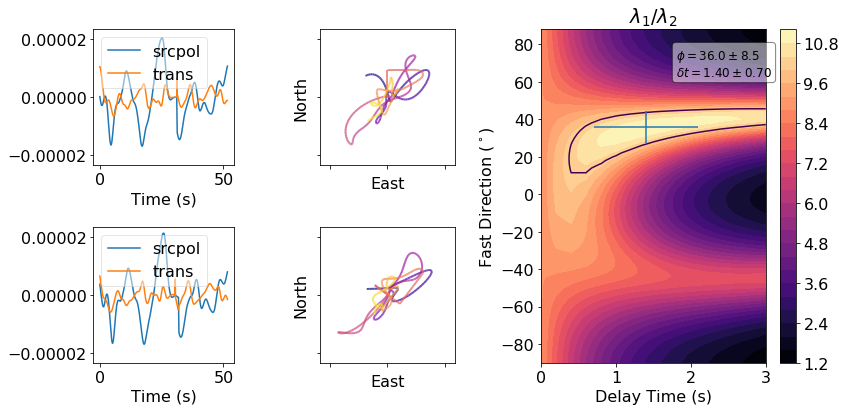

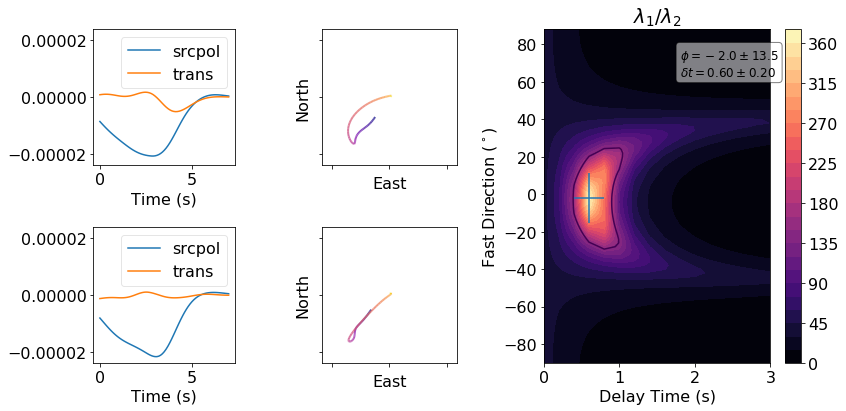

(-2.0, 13.5, 0.6, 0.2)

In [561]:
## to see if it is normal distributed

### LOAD IN BARRUOLS TABLE

## Catch the Degree of Freedom Error
# save VAlues to pickle file
# CHi Quadrat Test

Splitwave_TransM(st_cut,best_win_phi[0,0],best_win_phi[0,1],back_az,plot=True)

Splitwave_TransM(st_cut,best_win_dt[0,0],best_win_dt[0,1],back_az,plot=True)


81
54.2105263158
66.7894736842


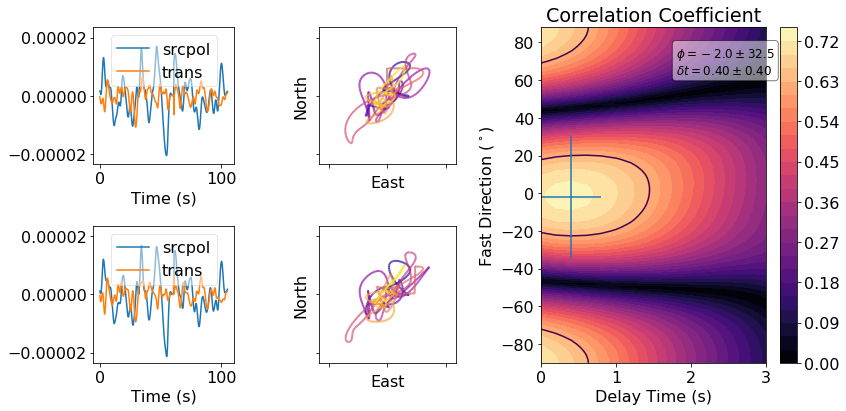

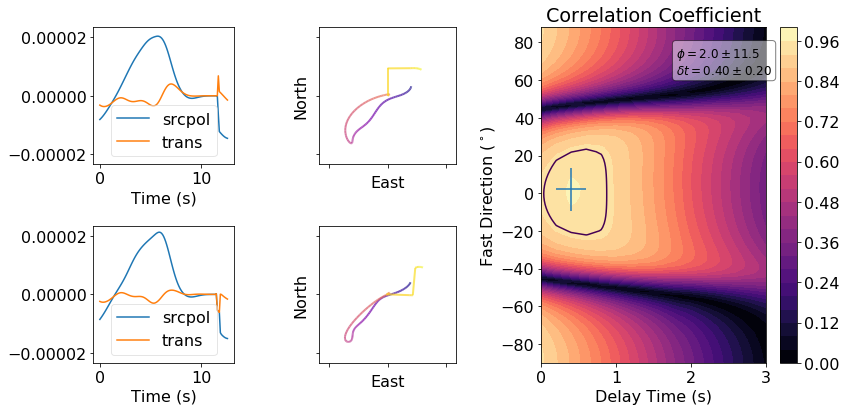

(2.0, 11.5, 0.4, 0.2)

In [570]:
print(len(ev_time_l))

## for bet phi window
print(best_win_phi[0,2])
print(best_win_phi[0,3])
Splitwave_CrossC(st_cut,5,110,plot=True)

## for bet time window
Splitwave_CrossC(st_cut,best_win_dt[0,2],best_win_dt[0,3],plot=True)


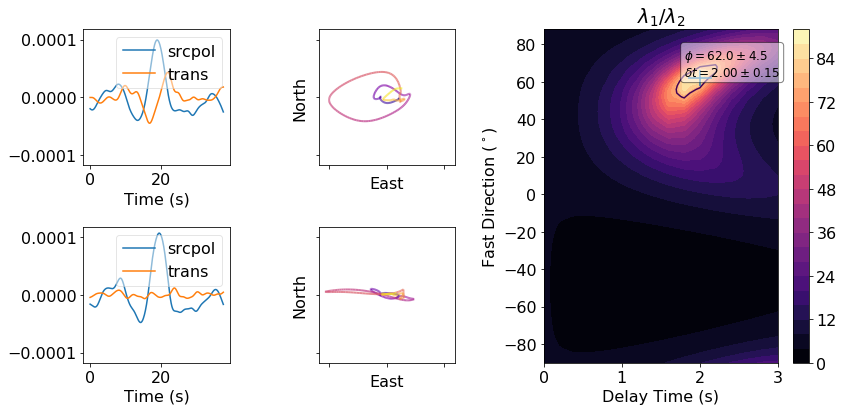

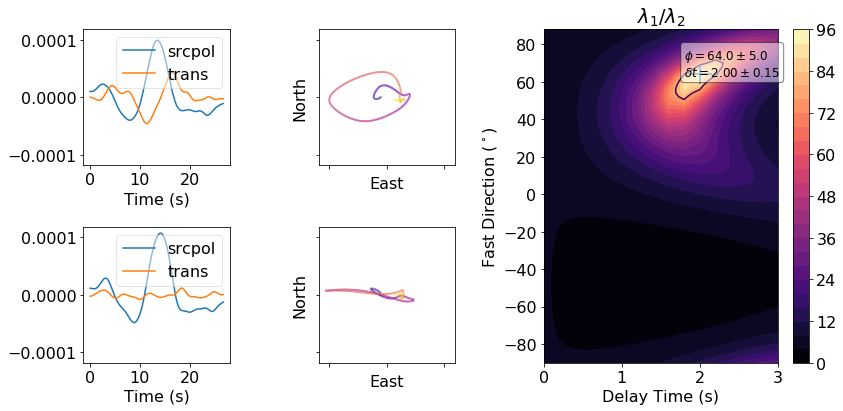

(64.0, 5.0, 2.0, 0.15)

In [423]:
Splitwave_EigM(st_cut,best_win_phi[0,4],best_win_phi[0,5],plot=True)

Splitwave_EigM(st_cut,best_win_dt[0,4],best_win_dt[0,5],plot=True)


In [ ]:

##  MAKE A WORKFLOW or TODOLIST of Things to test

## ---------
## TASK:
## look at the different time windows for different methods
## ---------
##  Note the pulse of energy is centred in the middle of the trace 
## -- this is deliberate -- it is a feature of this software that analysis is always done at the centre of traces.


#----------------------------------------------
## cluster analysis: Automated shear wave splititing using cluster analysis, Teanby
## F-Test
## bootstrap analysis by Sandvoll and Hearn 94
## k-means clustering algorithm, llok into Hands on ML notebook 08_dimension reduction, find out which Variable


## from Splitwave
## lambda1/lambda2 null classification
## error surface stacking 
## Bayesian inversion 

# mark as good, if energy well constrained to SKS arrival
# if too noisy, discard

#----------------------------------------------
## PLOTTING
# first window, whole event
# second zoom in to theoretical SKS
## choose different time windows depending on energy
## sort out bad ones
## collect in Intensity measurements and individual SKS m-s,
## show m-s and errorsurfaces of all three

## Check the criteria of W.
## look into Teanbys
## plot found fast direction against arrival angle
## if large variations, axis not horizontal?

#----------------------------------------------
## ADDITIONALY
## consider only looking at inclinations e.g. <1° or <5° ?

In [13]:
######################################################
### TASKS
######################################################

######################################################
## DO
######################################################
# READ IN THE FILES FROM /media/hein/home2/SplitWave_Data

######################################################
## DONE
######################################################

######################################################

### check for maximum value in window to identify real SKS Phase
### write out windows of waveforms..
### make flexible time window
### check out the main energy peak in FFT
### Plot all three channels with several incidence times
### Make a proper work flow:
### data exists? Any gaps or spikes?

## Parameters used in Walpols Study: 
## SKS epicentral distance between 95 < delta < 145° 
## distance from wikipedia: 60-141°
## SNR ratio >16
## weighted by SNR 
## Butterworth 0.02-0.1 Hz
## arrival time window between -15,-5 to +15,+30 s
## use eigenvalue method from silver and chan and cross correlation from Andow
## if both disagree by 45° --> Null measurements
## randomly sample and inspect for QC
## lambda2/lambda1 <0.025 (postcorrection), the smaller the fraction, the greater the linear particle motion
## SPOL-BAZ ??

In [ ]:
##### OLD
# ### PREPROCESSING
# ### response removed 
# ## linear detrended
# ### prefiltered 0.01 - 0.5
# ### decimated to 10 Hz

# ## anything else? Tapered around the edges


# ## example for 1 station for 1 EQ
# nevent=np.random.randint(0,len(ev_time_l))

# nevent=3
# print(nevent)
# st_selection = st_ev[3*nevent:3*nevent+3]
# #st_selection.plot()
# ## cut small time window around theoretical SKS-Arrival
# twin = 60
# s,f,t,slog,st_cut = calc_sft(st_selection,ev_time_l[nevent]+t_SKS_l[nevent]-twin,ev_time_l[nevent]+t_SKS_l[nevent]+twin)
# print(st_cut)
# st_cut.plot()

# ## calc Spectrogram of that slice and find out maximum energy peak between 5-50 s?
# plt.figure(figsize=(16,9))
# plt.subplot(2,1,1)
# plt.pcolormesh(t, 1/f[1:], slog[1:,:],vmin=slog.max()*1.2,cmap='plasma')
# plt.colorbar()
# #plt.ylim(0,10)

# plt.subplot(2,1,2)
# ## plot all three traces
# ## plot spectrograms and time plot with same time axis
# time = np.linspace(t[0],t[-1],len(st_cut[0].data))
# plt.plot(time,st_cut[0].data)

# plt.show()


# print(ev_time_l[nevent]+t_SKS_l[nevent])

# ## plot the arrival time,
# ## pick the maximum energy on t-domain
# ## and on f-domain
# ## frequency dependent filter?

# ## plot the different time windows
# ## get the width of the energy window
# ## rotate from ENZ, to ZNE to RTZ to LQT 


#power=2**3
#p,f = plt.psd(st_cut[0].data,NFFT= ,noverlap=int(2**power*0.5),pad_to=int(2**power*2),Fs=10,detrend='linear')
#print('x')
# T_h = 1/f
# plog = 10*np.log10(p)

# plt.plot(T_h,plog,color='black')    
# plt.xlim(0,30)
# plt.show()

## plot the spectrum of around max(abs(tr))



In [329]:
# max_percentage=0.05

# tr = st_cut[0].copy()
# tr_aux = st_cut[1].copy()

# tr.plot()
# tr_aux.plot()
# tr.taper(max_percentage, type='hann', max_length=None, side='both')


# f1 = np.arange(0.01,0.5,0.05)
# f2 = np.arange(0.02,0.6,0.05)
# #f1 = np.arange(0.05,1,0.05)
# #f2 = np.arange(0.1,1,0.05)


# SNR=1

# for if1 in range(0,len(f1)-1):
#     for if2 in range(0,len(f2)-1):
#         if if1<if2:
#             tr = st_cut[0].copy()
#             tr.taper(max_percentage, type='hann', max_length=None, side='both')
#             tr.filter("bandpass",freqmin=f1[if1],freqmax=f2[if2])
            
#             ## Assumption Noise calculation between 5% to 33% of the trace
#             tmp = np.max(tr.data)/(2*np.std(tr.data[int(len(tr)*0.05):int(len(tr)*1/3)]))
            
#             if tmp>SNR:
#                 SNR = tmp
#                 best_f1 = f1[if1]
#                 best_f2 = f2[if2]
                
                
                
# print(SNR)
# #best_f2 = 5**-1
# #best_f1 = 10**-1


# print(best_f1,best_f2)
# print(1/best_f2,1/best_f1)
# print(ev_time_l[nevent]+t_SKS_l[nevent])

# tr_1 = st_cut[0].copy()
# tr_2 = st_cut[1].copy()

# tr_1.filter("bandpass",freqmin=best_f1,freqmax=best_f2)
# tr_2.filter("bandpass",freqmin=best_f1,freqmax=best_f2)

# tr_1.taper(max_percentage, type='hann', max_length=None, side='both')
# tr_2.taper(max_percentage, type='hann', max_length=None, side='both')

# tr_1.plot()
# tr_2.plot(show=False)



# ## task: filter, then determine S/N ratio
# ## find best
# ## do it on the horizontal components, and improve SNR calculation?

In [725]:
# idx = np.where(abs(st_cut[0].data)==np.max(abs(st_cut[0].data)))
# print(idx)

# print(time[idx[0]])

# idx2 = np.where(t>time[idx[0]])

# print(idx2[0][0])
# plt.plot( 1/f[1:],slog[1:,idx2[0][0]])

# #plt.xlim(0.8,5)
# #plt.ylim(-180,-100)

In [ ]:
# import pickle

# array = np.array([0,5,1,6,4])
# array2 = np.array([1,5,5,5,5,5,5])


# pickle_dict ={ 'Stat_code': [st_cut[0].stats.station],
#              'Stat_lat': st_lat_l[nevent],
#              'Stat_lon': st_lon_l[nevent],
#              'Ev_lat': ev_lat_l[nevent],
#              'Ev_lon': ev_lat_l[nevent],
#              'Ev_depth': ev_depth_l[nevent],
#              'Ev_mag': ev_mag_l[nevent],
#              'fast_dir': values_1[np.argmin(values_1[:,1]),0],
#              'dfast': values_1[np.argmin(values_1[:,0]),0],
#              'lag': values_1[np.argmin(values_1[:,3]),2],
#              'dlag': values_1[np.argmin(values_1[:,3]),3],
#              'SNR': array2,
#              'window_param_t1': np.mean([best_win_dt[nevent,0],best_win_phi[nevent,0]]),
#              'window_param_t2': ,
#              'chi_squared': [chisquare_dt1],
#              'p_value': [p_dt1]}



                                
# filename_pickle = '{0}/{1}/SKS_Splitting_{2}_{1}.pickle'.format(path,method,station)
# with open(filename_pickle, 'wb') as handle:
#     pickle.dump(pickle_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(filename_pickle, 'rb') as handle:
#     b = pickle.load(handle)
    
# print(b.keys())

# for keys in b.keys():
#     print(type(b[keys]))
#     print(keys ,b[keys])
    